In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, kruskal, pointbiserialr, spearmanr
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator

from itertools import combinations

from utils import (
    rclr, 
    extract_id_pairs,
    get_values_from_distance_matrix,
    corr_sig,
    natural_keys,
    collect_data,
    collect_heatmap_data,
    draw_outlier_curve,
    draw_outliers_heatmap, 
    draw_annotated_alpha_div_boxplot,
    draw_annotated_barplot_within_vs_between
)

In [2]:
mapp = pd.read_csv('./data/mapping.txt', sep = '\t', na_values=["not provided", "not collected", "not applicable"])

In [3]:
taxa = pd.read_csv('./data/taxonomy/level-7.csv')

## Alpha diversity analysis

In [4]:
alpha_div = pd.read_csv("./data/faith-pd.tsv", sep="\t", index_col=0)

In [5]:
mapp["faith_pd"] = alpha_div

In [6]:
alpha_df = mapp[["#SampleID", "host_body_site", 
                 "maxillary_ostium_patency", "maxillary_ostium_size",
                  "frontal_ostium_patency"]].copy()
alpha_df = alpha_df.set_index("#SampleID").join(alpha_div).reset_index()
alpha_df.drop(1, inplace=True)

In [7]:
mapp.to_csv("metadata_alpha_div.csv")

## 1. Comparison of alpha diversity in different sampling sites

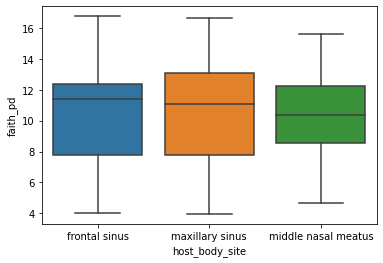

In [8]:
sns.boxplot(x="host_body_site", y="faith_pd", data=alpha_df);

In [9]:
from scipy.stats import kruskal
body_site=[]

for site in alpha_df.host_body_site.unique():
    pd_arr = alpha_df.groupby("host_body_site").get_group(site)["faith_pd"]
    body_site.append(pd_arr.dropna().values)

In [10]:
kruskal(*body_site)

KruskalResult(statistic=0.13974508649118889, pvalue=0.9325126673698564)

## 2. Comparison of alpha diversity with open and blocked *maxillary sinus ostium*

[(-0.5, 1.5)]

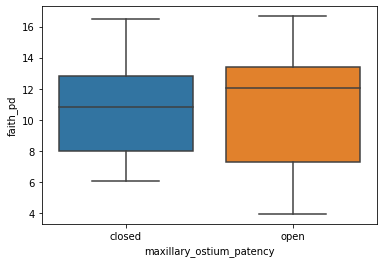

In [11]:
alpha_site = alpha_df[alpha_df["host_body_site"] == "maxillary sinus"]
g = sns.boxplot(x="maxillary_ostium_patency", y="faith_pd", data=alpha_site)
g.set(xlim=(-0.50, 1.5))

In [12]:
max_ost_state = []

max_sin_df = alpha_df.groupby("host_body_site").get_group("maxillary sinus")

for state in alpha_site.maxillary_ostium_patency.unique()[:-1]:
    pd_arr = max_sin_df.groupby("maxillary_ostium_patency").get_group(state)["faith_pd"]
    max_ost_state.append(pd_arr.dropna().values)
    
mannwhitneyu(*max_ost_state)

MannwhitneyuResult(statistic=159.0, pvalue=0.697843828250549)

## 3. Comparison of alpha diversity with different ostium patency

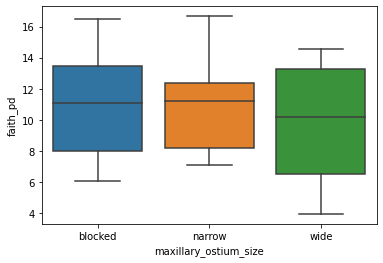

In [13]:
g = sns.boxplot(x="maxillary_ostium_size", y="faith_pd", data=alpha_site)
g.set(xlim=(-0.50, 2.5));

In [14]:
max_ost_state = []

for state in alpha_site.maxillary_ostium_size.unique()[:-1]:
    pd_arr = max_sin_df.groupby("maxillary_ostium_size").get_group(state)["faith_pd"]
    max_ost_state.append(pd_arr.dropna().values)
    
kruskal(*max_ost_state)

KruskalResult(statistic=0.3064552406657697, pvalue=0.8579344162670565)

## Distance matrix comparisons

In [15]:
dis_matrix = pd.read_csv("./data/distance-matrices/bc-sim-matrix.tsv", 
                         sep="\t", dtype = {"Unnamed: 0":str}).set_index("Unnamed: 0")

In [16]:
dis_matrix.index = dis_matrix.columns
ordered = list(dis_matrix.columns)
ordered.sort(key=natural_keys)
dis_matrix = dis_matrix.loc[ordered, ordered]

## 1. Outlier analysis

In [17]:
q3 = np.percentile(dis_matrix.to_numpy().ravel(), 90)

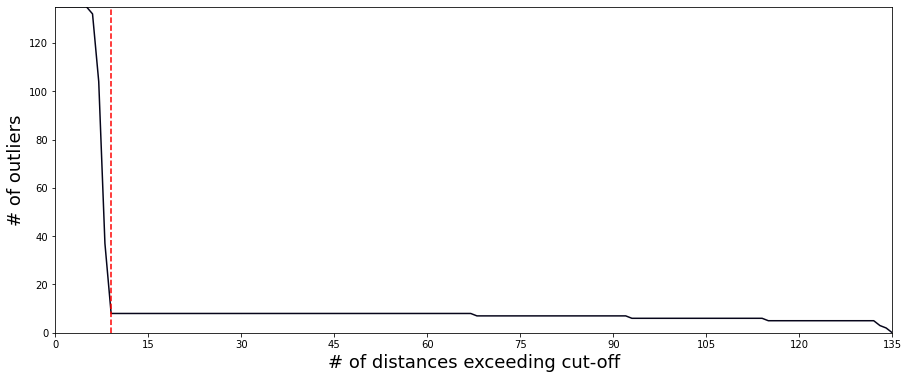

In [18]:
points = []
for n in range(0, 140):
    points.append(dis_matrix[dis_matrix > q3].dropna(thresh=n).shape[0])

fig = draw_outlier_curve(points)
fig.savefig("outlier_curve.png", dpi=600)

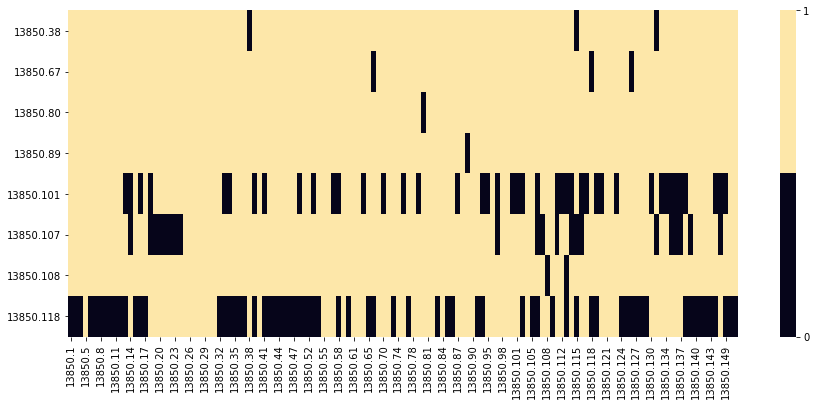

In [19]:
outliers_df = dis_matrix[dis_matrix > q3].dropna(thresh=9)
fig = draw_outliers_heatmap(outliers_df)
fig.savefig("outliers.png", dpi=600);

## 2. Beta diversity comparison

In [20]:
heatmap_pairs, heatmap_data = collect_heatmap_data(mapp, dis_matrix)

In [21]:
clean_bc_df = pd.DataFrame(heatmap_data).set_index(0).sort_index().dropna(how="all").rename(columns={1:"Meatus-frontal sinus",
                                                                                                     2:"Meatus-maxillary sinus",
                                                                                                     3:"Frontal-maxillary sinus"})
clean_bc_df.index.rename("host_subject_id", inplace=True)

patency = mapp[["host_subject_id", 
                "maxillary_ostium_size"]].drop_duplicates().dropna().set_index("host_subject_id").sort_index()

patency_df = clean_bc_df.join(patency)

narrow vs. blocked: Mann-Whitney-Wilcoxon test two-sided, P_val:5.689e-02 U_stat=1.370e+02
narrow vs. blocked: Mann-Whitney-Wilcoxon test two-sided, P_val:2.817e-02 U_stat=1.560e+02
narrow vs. wide: Mann-Whitney-Wilcoxon test two-sided, P_val:8.057e-02 U_stat=7.300e+01


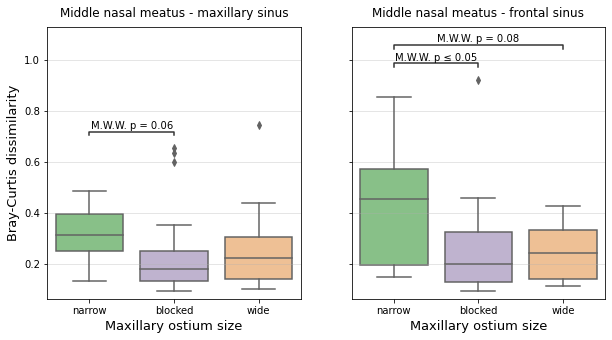

In [22]:
fig = draw_annotated_alpha_div_boxplot(patency_df)
fig.savefig("beta_div_ostia_status_body_site.png", dpi=600);

## 3. Within vs. between analysis

In [23]:
column_pairs = [x for x in combinations(heatmap_pairs.columns, 2)]

res = heatmap_pairs.apply(extract_id_pairs, args=(column_pairs), axis=1)
slist = [st.values for row in res for st in row]
within_df = pd.DataFrame(slist)
within_df.columns = ["1st_sample", "2nd_sample", "distance", "distance_type", "host_subject_id"]

In [24]:
for row in within_df.iterrows():
    between_patients = pd.DataFrame()
    between_patients["2nd_sample"] = heatmap_pairs[row[1]["distance"].split("-")[1]].drop(row[1]["host_subject_id"])
    between_patients["1st_sample"] = row[1]["1st_sample"]
    between_patients["distance"] = row[1]["distance"]
    between_patients["distance_type"] = "between"
    between_patients["host_subject_id"] = np.nan
    within_df = pd.concat([within_df, between_patients], axis=0, ignore_index=True)

In [25]:
within_df["distance_value"] = within_df[["1st_sample", "2nd_sample"]].apply(get_values_from_distance_matrix, 
                                                                            args=(dis_matrix,), axis=1)

meatus_id-frontal_id_within vs. meatus_id-frontal_id_between: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.523e-03 U_stat=2.677e+04
meatus_id-maxillary_id_within vs. meatus_id-maxillary_id_between: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.776e-04 U_stat=2.231e+04
maxillary_id-frontal_id_within vs. maxillary_id-frontal_id_between: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.320e-02 U_stat=3.621e+04


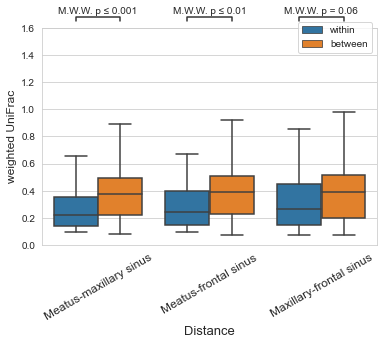

In [26]:
g = draw_annotated_barplot_within_vs_between(within_df)
plt.gcf().savefig("within-bc.png", dpi=600, bbox_inches="tight");

In [27]:
super_df = collect_data(within_df, outliers_df, mapp)

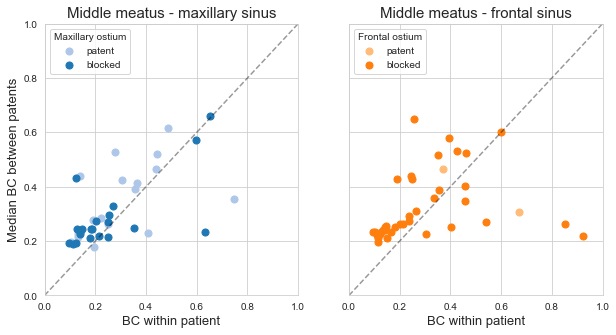

In [28]:
titles = ["Middle meatus - maxillary sinus", 
          "Middle meatus - frontal sinus", 
          "Maxillary sinus - frontal sinus"]
features = ["maxillary_ostium_patency",
            "frontal_ostium_patency"]
leg_titles = ["Maxillary ostium", "Frontal ostium"]


fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
for n, (distance, ax, title) in enumerate(zip(super_df.distance.dropna().unique(), axes, titles)):
    normal_df = super_df[(super_df["distance"] == distance) & (super_df[features[n]] == "open")]
    ax.scatter(normal_df.within, normal_df.between, label="patent", color=plt.cm.tab20(n*2 + 1), s=50)

    blocked_df = super_df[(super_df["distance"] == distance) & (super_df[features[n]] == "closed")]
    ax.scatter(blocked_df.within, blocked_df.between, label="blocked", color=plt.cm.tab20(n*2), s=50)

    ax.plot([0, 1], [0, 1], linestyle="--", color="k", alpha=0.4)
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.set_xlabel("BC within patient", fontsize=13)
    ax.set_title(title, fontsize=15)

    if n == 0:
        ax.set_ylabel("Median BC between patents", fontsize=13)
    ax.legend(title=leg_titles[n])

fig.savefig("distances-scatterplot.png", dpi=600)

Meatus-frontal sinus vs. Meatus-maxillary sinus: Mann-Whitney-Wilcoxon test two-sided, P_val:5.722e-01 U_stat=8.170e+02
Meatus-maxillary sinus vs. Frontal-maxillary sinus: Mann-Whitney-Wilcoxon test two-sided, P_val:3.712e-01 U_stat=7.220e+02
Meatus-frontal sinus vs. Frontal-maxillary sinus: Mann-Whitney-Wilcoxon test two-sided, P_val:6.130e-01 U_stat=8.040e+02


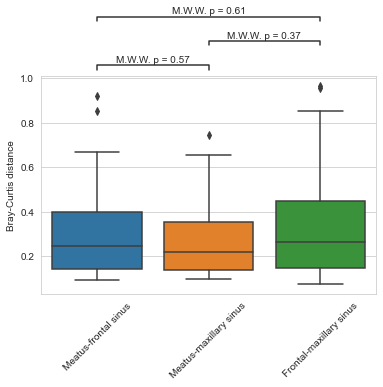

In [31]:
g = sns.boxplot(x="variable", y="value", data=pd.melt(clean_bc_df))
g.set(xlabel="", ylabel="Bray-Curtis distance")
plt.xticks(rotation=45); 

annotator = Annotator(g, [pair for pair in combinations(clean_bc_df.columns, 2)], data=pd.melt(clean_bc_df), x="variable", y="value")
annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')
annotator.apply_and_annotate();

## 4. Heatmap

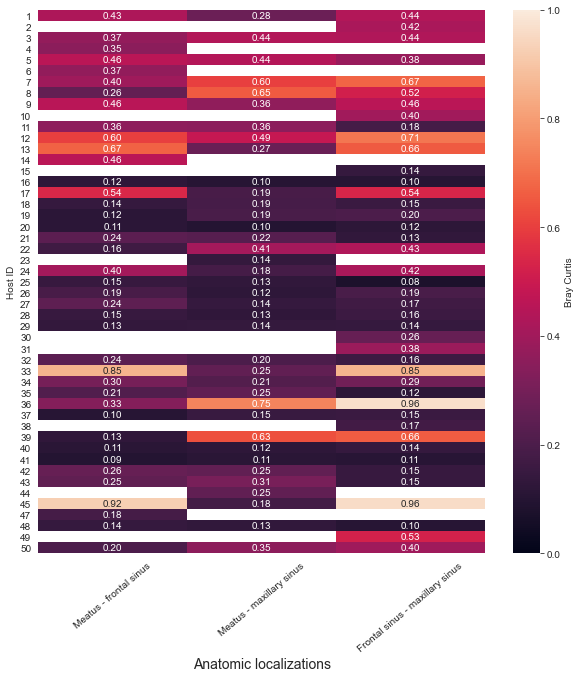

In [30]:
fig, g = plt.subplots(figsize=(10, 10))

g = sns.heatmap(clean_bc_df,
                cbar_kws={'label': 'Bray Curtis'}, 
                annot=True, fmt=".2f", 
                vmin=0, 
                vmax=1)

g.set_ylabel("Host ID")
g.set_xticklabels(["Meatus - frontal sinus", 
                   "Meatus - maxillary sinus", 
                   "Frontal sinus - maxillary sinus"], 
                  rotation=40)

g.set_xlabel("Anatomic localizations", fontsize=14)
plt.setp(g.get_yticklabels(), rotation=0);